# BOW and TFIDF on reddit data

Now we will analyze text data of reddit.com/r/news 

The data was downloaded 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import nltk
import string
from wordcloud import WordCloud
from nltk.corpus import stopwords
nltk.download('stopwords')
from sklearn.feature_extraction.text import CountVectorizer
from nltk.tokenize import RegexpTokenizer, word_tokenize, TweetTokenizer
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import confusion_matrix
import re

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\magdalena.kalbarczyk\AppData\Roaming\nltk_dat
[nltk_data]     a...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\magdalena.kalbarczyk\AppData\Roaming\nltk_dat
[nltk_data]     a...
[nltk_data]   Package wordnet is already up-to-date!


#### There were many titles which were not in english. We had to use lang_detect package in order to select only english titles.

In [2]:
news_reddit = pd.read_csv('../data/news_lang.csv', sep=";")

In [3]:
news_reddit.shape

(783704, 5)

In [4]:
news_reddit = news_reddit[news_reddit["lang"]=="en"]

In [5]:
news_reddit.shape

(582523, 5)

In [6]:
news_reddit.columns

Index(['title', 'score', 'num_comments', 'created_utc', 'lang'], dtype='object')

In [7]:
news_reddit.head()

,title,score,num_comments,created_utc,lang
0,Texas teen tackled by cop at pool party files ...,0,0,1483629018,en
1,John Kerry In Leaked Audio Admits U.S. Allowed...,0,0,1483872751,en
2,2017 American Liberty 225th Anniversary Gold C...,0,0,1484327875,en
3,Repair broken glass with Sensible cost | Call ...,0,0,1484798494,en
4,Today is the last day to register for Obamacare,0,0,1485872414,en


In [8]:
news_reddit.groupby('score').\
    apply(lambda x: len(x)).\
    sort_values().nlargest(10)

score
1    498843
0     12373
2     10387
3      4936
4      2893
5      2776
6      2394
7      2014
8      1702
9      1465
dtype: int64

In [9]:
news_reddit.groupby('score').\
    apply(lambda x: len(x)).\
    sort_values().nsmallest(10)

score
2559    1
5285    1
5304    1
5306    1
5314    1
5324    1
5325    1
5350    1
5372    1
5374    1
dtype: int64

In [10]:
news_reddit[news_reddit['score']<=1].shape

(511216, 5)

In [11]:
news_reddit[news_reddit['score']>1].shape

(71307, 5)

In [12]:
ones = news_reddit[news_reddit['score']==1].sample(n=(news_reddit[news_reddit['score']>1].shape[0]-news_reddit[news_reddit['score']==0].shape[0]))
zeros = news_reddit[news_reddit['score']==0]
rest = news_reddit[news_reddit['score']>1]

news_reddit = pd.concat([ones, zeros, rest])
news_reddit.sample(frac=1)
news_reddit.head()

,title,score,num_comments,created_utc,lang
243616,Platinum Transportation Provide Shuttle to and...,1,0,1506927380,en
229874,"For Drone Pilots, Warfare May Be Remote But Th...",1,0,1493059694,en
371471,The Top 4 Benefits of Using Video Surveillance...,1,0,1507789966,en
221923,"Self-Storage Storage Quarters - Garden City, N...",1,0,1488380450,en
504505,"Calvin Harris reveals why he ""exploded"" before...",1,0,1498906741,en


In [13]:
news_reddit['title'][0]

'Texas teen tackled by cop at pool party files lawsuit'

## What were reddit posts about?
* Data preprocesing
* WordCloud

In [14]:
stop = set(stopwords.words('english'))

In [15]:
news_reddit.head()

,title,score,num_comments,created_utc,lang
243616,Platinum Transportation Provide Shuttle to and...,1,0,1506927380,en
229874,"For Drone Pilots, Warfare May Be Remote But Th...",1,0,1493059694,en
371471,The Top 4 Benefits of Using Video Surveillance...,1,0,1507789966,en
221923,"Self-Storage Storage Quarters - Garden City, N...",1,0,1488380450,en
504505,"Calvin Harris reveals why he ""exploded"" before...",1,0,1498906741,en


#### There were some difficulties when tokenizing data. NLTK offers many different tokenizers
* Tokenizer: word_tokenize - problem with words like it's, isn't
* Tokenizer: TweetTokenizer - problem with words like "U.S.A."

#### How to deal with the problem?

In [16]:
tokenizer1 = word_tokenize("He isn't in the U.S.A. today")
tokenizer1

['He', 'is', "n't", 'in', 'the', 'U.S.A.', 'today']

In [17]:
tokenizer2 = TweetTokenizer()
tokenizer2. tokenize("He isn't in the U.S.A. today")

['He', "isn't", 'in', 'the', 'U', '.', 'S', '.', 'A', '.', 'today']

#### Finally we decided to do it in our own way! We delete everything after apostrophe and than define RegexpTokenizer.

In [18]:
news_reddit["title"] = news_reddit['title'].apply(lambda x:  re.sub(r"\'.+?", '', x))
pattern = r'[\d.,]+|[A-Z][.A-Z]+\b\.*|\w+|\S'
tokenizer = RegexpTokenizer(pattern)
news_reddit["tokenized_titles"] = news_reddit['title'].apply(lambda x: tokenizer.tokenize(x.lower()))

In [19]:
news_reddit.iloc[0:15,:]

,title,score,num_comments,created_utc,lang,tokenized_titles
243616,Platinum Transportation Provide Shuttle to and...,1,0,1506927380,en,"[platinum, transportation, provide, shuttle, t..."
229874,"For Drone Pilots, Warfare May Be Remote But Th...",1,0,1493059694,en,"[for, drone, pilots, ,, warfare, may, be, remo..."
371471,The Top 4 Benefits of Using Video Surveillance...,1,0,1507789966,en,"[the, top, 4, benefits, of, using, video, surv..."
221923,"Self-Storage Storage Quarters - Garden City, N...",1,0,1488380450,en,"[self, -, storage, storage, quarters, -, garde..."
504505,"Calvin Harris reveals why he ""exploded"" before...",1,0,1498906741,en,"[calvin, harris, reveals, why, he, "", exploded..."
28960,Sneaky snake causes cancellation of flight,1,0,1483962776,en,"[sneaky, snake, causes, cancellation, of, flight]"
192640,Ben Carson Is Confirmed as HUD Secretary,1,0,1488475586,en,"[ben, carson, is, confirmed, as, hud, secretary]"
221613,Miniature Golf Supplies,1,0,1490619000,en,"[miniature, golf, supplies]"
328297,Australian Government Data Portal Development,1,0,1495697096,en,"[australian, government, data, portal, develop..."
474290,Beat the Slow Functioning from AC Repair Plant...,1,0,1508217841,en,"[beat, the, slow, functioning, from, ac, repai..."


In [20]:
news_reddit['tokenized_titles'] = news_reddit['tokenized_titles'].apply(lambda x: [item for item in x if item not in stop])
news_reddit.head()

,title,score,num_comments,created_utc,lang,tokenized_titles
243616,Platinum Transportation Provide Shuttle to and...,1,0,1506927380,en,"[platinum, transportation, provide, shuttle, h..."
229874,"For Drone Pilots, Warfare May Be Remote But Th...",1,0,1493059694,en,"[drone, pilots, ,, warfare, may, remote, traum..."
371471,The Top 4 Benefits of Using Video Surveillance...,1,0,1507789966,en,"[top, 4, benefits, using, video, surveillance,..."
221923,"Self-Storage Storage Quarters - Garden City, N...",1,0,1488380450,en,"[self, -, storage, storage, quarters, -, garde..."
504505,"Calvin Harris reveals why he ""exploded"" before...",1,0,1498906741,en,"[calvin, harris, reveals, "", exploded, "", rant..."


## Lemmas

In [21]:
lemmatizer = WordNetLemmatizer()
news_reddit['lemmatized_titles'] = news_reddit['tokenized_titles'].apply(lambda x: [lemmatizer.lemmatize(item) for item in x])

In [22]:
news_reddit.iloc[1:50,:]

,title,score,num_comments,created_utc,lang,tokenized_titles,lemmatized_titles
229874,"For Drone Pilots, Warfare May Be Remote But Th...",1,0,1493059694,en,"[drone, pilots, ,, warfare, may, remote, traum...","[drone, pilot, ,, warfare, may, remote, trauma..."
371471,The Top 4 Benefits of Using Video Surveillance...,1,0,1507789966,en,"[top, 4, benefits, using, video, surveillance,...","[top, 4, benefit, using, video, surveillance, ..."
221923,"Self-Storage Storage Quarters - Garden City, N...",1,0,1488380450,en,"[self, -, storage, storage, quarters, -, garde...","[self, -, storage, storage, quarter, -, garden..."
504505,"Calvin Harris reveals why he ""exploded"" before...",1,0,1498906741,en,"[calvin, harris, reveals, "", exploded, "", rant...","[calvin, harris, reveals, "", exploded, "", rant..."
28960,Sneaky snake causes cancellation of flight,1,0,1483962776,en,"[sneaky, snake, causes, cancellation, flight]","[sneaky, snake, cause, cancellation, flight]"
192640,Ben Carson Is Confirmed as HUD Secretary,1,0,1488475586,en,"[ben, carson, confirmed, hud, secretary]","[ben, carson, confirmed, hud, secretary]"
221613,Miniature Golf Supplies,1,0,1490619000,en,"[miniature, golf, supplies]","[miniature, golf, supply]"
328297,Australian Government Data Portal Development,1,0,1495697096,en,"[australian, government, data, portal, develop...","[australian, government, data, portal, develop..."
474290,Beat the Slow Functioning from AC Repair Plant...,1,0,1508217841,en,"[beat, slow, functioning, ac, repair, plantation]","[beat, slow, functioning, ac, repair, plantation]"
588358,Millions prepare to watch rare total solar ecl...,1,0,1503313621,en,"[millions, prepare, watch, rare, total, solar,...","[million, prepare, watch, rare, total, solar, ..."


In [23]:
news_reddit['lemmatized_titles'] = news_reddit['lemmatized_titles'].apply(lambda x:  [''.join(c for c in s if c not in string.punctuation) for s in x])
news_reddit['lemmatized_titles'] = news_reddit['lemmatized_titles'].apply(lambda x:  [s for s in x if s])

In [24]:
news_reddit.iloc[1:20,:]

,title,score,num_comments,created_utc,lang,tokenized_titles,lemmatized_titles
229874,"For Drone Pilots, Warfare May Be Remote But Th...",1,0,1493059694,en,"[drone, pilots, ,, warfare, may, remote, traum...","[drone, pilot, warfare, may, remote, trauma, r..."
371471,The Top 4 Benefits of Using Video Surveillance...,1,0,1507789966,en,"[top, 4, benefits, using, video, surveillance,...","[top, 4, benefit, using, video, surveillance, ..."
221923,"Self-Storage Storage Quarters - Garden City, N...",1,0,1488380450,en,"[self, -, storage, storage, quarters, -, garde...","[self, storage, storage, quarter, garden, city..."
504505,"Calvin Harris reveals why he ""exploded"" before...",1,0,1498906741,en,"[calvin, harris, reveals, "", exploded, "", rant...","[calvin, harris, reveals, exploded, ranting, t..."
28960,Sneaky snake causes cancellation of flight,1,0,1483962776,en,"[sneaky, snake, causes, cancellation, flight]","[sneaky, snake, cause, cancellation, flight]"
192640,Ben Carson Is Confirmed as HUD Secretary,1,0,1488475586,en,"[ben, carson, confirmed, hud, secretary]","[ben, carson, confirmed, hud, secretary]"
221613,Miniature Golf Supplies,1,0,1490619000,en,"[miniature, golf, supplies]","[miniature, golf, supply]"
328297,Australian Government Data Portal Development,1,0,1495697096,en,"[australian, government, data, portal, develop...","[australian, government, data, portal, develop..."
474290,Beat the Slow Functioning from AC Repair Plant...,1,0,1508217841,en,"[beat, slow, functioning, ac, repair, plantation]","[beat, slow, functioning, ac, repair, plantation]"
588358,Millions prepare to watch rare total solar ecl...,1,0,1503313621,en,"[millions, prepare, watch, rare, total, solar,...","[million, prepare, watch, rare, total, solar, ..."


## WordCloud

In [25]:
list_of_words = [y for x in news_reddit['lemmatized_titles'] for y in x]
wordfreqdist = nltk.FreqDist(list_of_words)
mostcommon = wordfreqdist.most_common(30)
print(mostcommon)

[('’', 11348), ('u', 8603), ('trump', 8050), ('say', 6372), ('news', 6218), ('man', 6009), ('police', 5622), ('new', 5554), ('year', 5504), ('woman', 4470), ('‘', 4022), ('2017', 3294), ('service', 2910), ('old', 2722), ('get', 2669), ('state', 2522), ('amp', 2441), ('report', 2410), ('best', 2391), ('dead', 2383), ('attack', 2346), ('shooting', 2276), ('time', 2242), ('video', 2226), ('killed', 2220), ('house', 2209), ('arrested', 2204), ('north', 2194), ('school', 2183), ('first', 2173)]


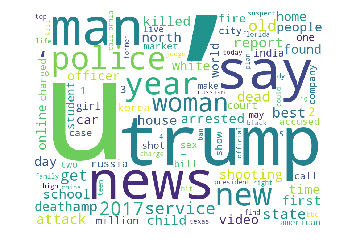

In [26]:
wordcloud = WordCloud(width=800, height=600, relative_scaling = 1.0, background_color='white', max_words=100).generate_from_frequencies(wordfreqdist)
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

In [27]:
news_reddit['final_titles'] = news_reddit['lemmatized_titles'].apply(lambda x:  ' '.join(x))
news_reddit.head()

,title,score,num_comments,created_utc,lang,tokenized_titles,lemmatized_titles,final_titles
243616,Platinum Transportation Provide Shuttle to and...,1,0,1506927380,en,"[platinum, transportation, provide, shuttle, h...","[platinum, transportation, provide, shuttle, h...",platinum transportation provide shuttle hotel ...
229874,"For Drone Pilots, Warfare May Be Remote But Th...",1,0,1493059694,en,"[drone, pilots, ,, warfare, may, remote, traum...","[drone, pilot, warfare, may, remote, trauma, r...",drone pilot warfare may remote trauma real
371471,The Top 4 Benefits of Using Video Surveillance...,1,0,1507789966,en,"[top, 4, benefits, using, video, surveillance,...","[top, 4, benefit, using, video, surveillance, ...",top 4 benefit using video surveillance business
221923,"Self-Storage Storage Quarters - Garden City, N...",1,0,1488380450,en,"[self, -, storage, storage, quarters, -, garde...","[self, storage, storage, quarter, garden, city...",self storage storage quarter garden city ny 11...
504505,"Calvin Harris reveals why he ""exploded"" before...",1,0,1498906741,en,"[calvin, harris, reveals, "", exploded, "", rant...","[calvin, harris, reveals, exploded, ranting, t...",calvin harris reveals exploded ranting taylor ...


In [29]:
news_reddit['y'] = np.where(news_reddit['score']<=1, 0, 1)
news_reddit = news_reddit.sample(frac=1.0)
news_reddit.head()

,title,score,num_comments,created_utc,lang,tokenized_titles,lemmatized_titles,final_titles,y
765780,Woman arrested for leaving 3-year-old locked i...,1849,325,1511527174,en,"[woman, arrested, leaving, 3, -, year, -, old,...","[woman, arrested, leaving, 3, year, old, locke...",woman arrested leaving 3 year old locked car s...,1
712898,Snapchat $2.2 Billion Loss Caps Bumpy First Mo...,2,0,1494463307,en,"[snapchat, $, 2.2, billion, loss, caps, bumpy,...","[snapchat, 22, billion, loss, cap, bumpy, firs...",snapchat 22 billion loss cap bumpy first month...,1
734536,Pennsylvania man convicted of attempted rape w...,6,9,1501479459,en,"[pennsylvania, man, convicted, attempted, rape...","[pennsylvania, man, convicted, attempted, rape...",pennsylvania man convicted attempted rape wrot...,1
231424,Nike becomes first major brand to launch hijab...,1,0,1489080410,en,"[nike, becomes, first, major, brand, launch, h...","[nike, becomes, first, major, brand, launch, h...",nike becomes first major brand launch hijab woman,0
403453,Laura Ingraham Destroys Traitor GOPs For What ...,1,0,1493600345,en,"[laura, ingraham, destroys, traitor, gops, ’, ...","[laura, ingraham, destroys, traitor, gop, ’, s...",laura ingraham destroys traitor gop ’ sabotage...,0


## Bag Of Words - BoW

Bag of words is a text representation and a way of extracting features. In BoW a document is understood as a bag containing words without taking care of order of words or sentences. 
This kind of representation of text involves a vocabulary and a measure of presence of words.

In [30]:
bow_transformer = CountVectorizer()
bow_transformer.fit(news_reddit['final_titles'])


CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
        tokenizer=None, vocabulary=None)

In [31]:
example_bow = bow_transformer.transform([news_reddit["final_titles"][0]])

In [32]:
print(example_bow)

  (0, 12646)	1
  (0, 19946)	1
  (0, 30144)	1
  (0, 39256)	1
  (0, 40884)	1
  (0, 51384)	1
  (0, 51884)	1
  (0, 52213)	1


In [33]:
titles_bow = bow_transformer.transform(news_reddit["final_titles"])

In [34]:
print ('Shape of Sparse Matrix: ', titles_bow.shape)
print ('Amount of Non-Zero occurences: ', titles_bow.nnz)

Shape of Sparse Matrix:  (142614, 59310)
Amount of Non-Zero occurences:  1124291


### TFIDF - Term Frequency-Inverse Document Frequency

Statistical measure, which is used to check how important the word is in to the document in whole corpus. The importance increases proportionally to the number of occurences of word in document, but is offset by the frequency of the word in the corpus.


Tfidf = TF x IDF

* TF(x) = (number of occurences of word in document) / (number of words in document)
* IDF(x) = ln(number fo documents/number of documents containing this word)



In [35]:
from sklearn.feature_extraction.text import TfidfTransformer
tfidf_transformer = TfidfTransformer().fit(titles_bow)

In [36]:
print(tfidf_transformer.transform(example_bow))

  (0, 52213)	0.28003851677685043
  (0, 51884)	0.28003851677685043
  (0, 51384)	0.5408658780931073
  (0, 40884)	0.38421976822047105
  (0, 39256)	0.3289589302574822
  (0, 30144)	0.31777191138286204
  (0, 19946)	0.32805232812982343
  (0, 12646)	0.29357253688749735


In [37]:
titles_tfidf = tfidf_transformer.transform(titles_bow)

## Models

### Model on bow - count

In [38]:
X_train_bow, X_test_bow, Y_train_bow, Y_test_bow = train_test_split(titles_bow, news_reddit['y'], test_size=0.3, random_state=1)

In [39]:
clf = MultinomialNB()
clf.fit(X_train_bow, Y_train_bow)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [40]:
clf.score(X_test_bow,Y_test_bow)

0.760359939231039

In [43]:
Y_pred_bow = (clf.predict(X_test_bow))
confusion_matrix(Y_test_bow, Y_pred_bow)

array([[14645,  6825],
       [ 3428, 17887]], dtype=int64)

### Model on TF-IDF

In [44]:
X_train_tfidf, X_test_tfidf, Y_train_tfidf, Y_test_tfidf = train_test_split(titles_tfidf, news_reddit['y'], test_size=0.3, random_state=1)

In [45]:
clf = MultinomialNB()
clf.fit(X_train_tfidf, Y_train_tfidf)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [46]:
clf.score(X_test_tfidf,Y_test_tfidf)

0.7596821315881734

In [47]:
Y_pred_tfidf = (clf.predict(X_test_tfidf))
confusion_matrix(Y_test_tfidf, Y_pred_tfidf)

array([[14253,  7217],
       [ 3065, 18250]], dtype=int64)